In [179]:
import numpy as np
from matplotlib import pyplot as plt
import random

# Input Data

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

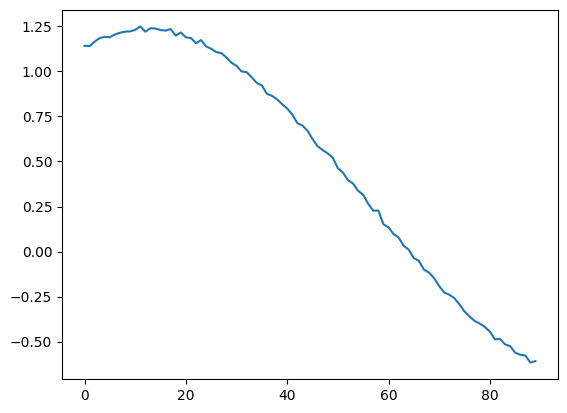

In [180]:
sample_count = 128
vals_per_sample = 90

drift = 0.001
sin_coeff = 2

input_data = []
gts = []

for i in range(sample_count):
    start_deg = random.randint(0, 359)
    one_hot = np.zeros(360)
    one_hot[start_deg] = 1
    true_vals = np.zeros(vals_per_sample)
    for j in range(vals_per_sample):
        current_deg = start_deg + j
        true_vals[j] = np.sin(np.radians(sin_coeff * current_deg)) + np.random.normal(0,0.01) + current_deg * drift
    input_data.append(one_hot)
    gts.append(true_vals)
        
print(input_data[0])
plt.plot(np.arange(vals_per_sample),gts[0])

# Model

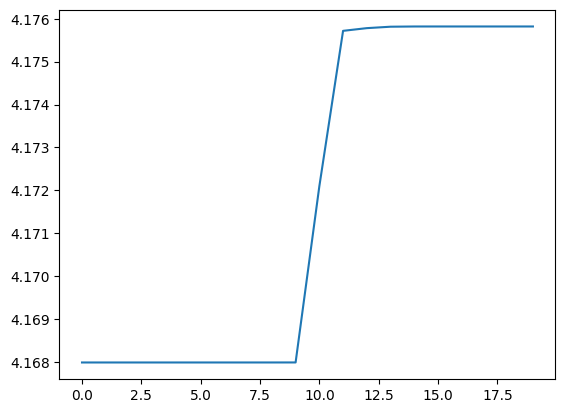

In [181]:
# Modified from https://github.com/KTAswathi/IPB_2023/blob/main/IPB_lab3_BPTT.ipynb

import numpy as np
from numpy.random import randn

class RNN:
    # A Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        # Weights
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000
        self.Wfeedback = randn(hidden_size, output_size) / 1000
        self.h_init =  np.random.normal(0,0.00001,(self.Whh.shape[0], 1))
    
    #Should take one hot input vector
    def forward(self, inputs, pred_weight, lr, gts):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        h = self.h_init
        #h = np.zeros(self.Whh.shape[0])

        #self.last_hs = { 0: h }
        self.last_pred = { 0: h }

        outputs = []
        loss = []

        x = inputs
        
        # Perform each step of the RNN
        for i, y_true in enumerate(gts):
            #h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            #self.last_hs[i + 1] = h

            #h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            h = h + self.Whh @ np.tanh(h)
            
            # Compute prediction and prediction error signal
            y = self.Why @ np.tanh(h)

            output_error = y_true - y
            outputs.append(y[0][0])

            h_pred = h + pred_weight * self.Wfeedback @ output_error # Might need to do something to dot these
            pred_error = h_pred - h
            self.last_pred[i + 1] = h_pred

            # print(pred_error.shape)
            # print(self.last_pred[i].shape)
            self.Whh = self.Whh + lr * pred_error @ np.transpose(np.tanh(self.last_pred[i]))
            self.Wfeedback = self.Wfeedback + lr * np.tanh(h) @ np.transpose(output_error)

            loss.append(np.abs(np.mean(output_error)))
            
        return outputs, np.mean(loss)
        # Compute the output
        # y = self.Why @ h + self.by
        # return y

rnn = RNN(360,1,hidden_size=100)

avg_loss = []

epochs = 20

for epoch in range(epochs):
    total_loss = 0
    for i in range(len(input_data)):
        _, loss = rnn.forward(input_data[i], 0.01, 0.1, gts[i])
        total_loss += loss
    avg_loss.append(total_loss/epochs)
    
sequence, _ = rnn.forward(input_data[1], 0.0001, 0.1, gts[1])

plt.plot(np.arange(epochs),avg_loss)
#plt.plot(np.arange(90),gts[i])
plt.show()